In [1]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

import nltk
from nltk import word_tokenize

import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\merecat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\merecat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\merecat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df_purged = pd.read_csv("data/Sports_and_Outdoors_5.csv")
df_purged = df_purged.dropna()

In [5]:
len(df_purged)

2838824

In [6]:
df_purged.head()

,Unnamed: 0,reviewText,overall,label
0,0,What a spectacular tutu! Very slimming.,5.0,2.0
1,1,What the heck? Is this a tutu for nuns? I know...,1.0,0.0
2,2,Exactly what we were looking for!,5.0,2.0
3,3,I used this skirt for a Halloween costume and ...,5.0,2.0
4,4,This is thick enough that you can't see throug...,4.0,2.0


In [11]:
from sklearn.utils import resample
# Separate positive, neutral and negative classes
df_pos = df_purged[df_purged.label==2]
df_neut = df_purged[df_purged.label==1]
df_neg = df_purged[df_purged.label==0]
n_sample = 600000
print(n_sample)
# Downsample majority class
df_pos_downsampled = resample(df_pos, 
                              replace=False,    # sample without replacement
                              n_samples=n_sample,     # to match minority class
                              random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_purged = pd.concat([df_pos_downsampled, df_neut, df_neg])
 
# Display new class counts
df_purged.label.value_counts()

600000


2.0    600000
0.0    212758
1.0    210179
Name: label, dtype: int64

In [18]:
df_purged = df_purged[['reviewText', 'overall', 'label']].reset_index(drop=True)
df_purged.to_pickle("data/Sports_and_Outdoors_5_balanced.csv")

In [12]:
# check how balanced the training dataset is
df_purged.groupby(['label']).count()

,Unnamed: 0,reviewText,overall
label,,,
0.0,212758,212758,212758
1.0,210179,210179,210179
2.0,600000,600000,600000


In [13]:
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

In [14]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [15]:
import re
import string

# remove emojis: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

# data preprocessing
def preprocess_text(text):
    
    stop_words = set(stopwords.words('english'))
    # replacing url-s with the word 'url'
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','', text)
    # replacing usernames-s with the word 'user'
    text = re.sub('@[^\s]+','', text)
    # converting text to lowercase
    text = text.lower()
    # remove HTML tags
    text = re.sub('<.*?>', '', text)
    # remove punctuation marks
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    # remove multiple spaces
    text = re.sub(' +',' ', text)
    # replacing numbers with the word 'number'
    text = re.sub(r'\w*\d+\w*', '', text)
    
    tokens = word_tokenize(text)
    
    cleaned_text = [w for w in tokens if not w.lower() in stop_words]
    
    cleaned_text = [w for w in cleaned_text if len(w)>2]

    # text = deEmojify(text)
    
    return cleaned_text


In [16]:
# df_purged["reviewText"] = [replace_contractions(t) for t in tqdm(df_purged.reviewText)]
text_prep = [preprocess_text(t) for t in tqdm(df_purged.reviewText)]
# test_list = [preprocess_text(t) for t in tqdm(df_purged.reviewText[500:1000])]

  0%|          | 0/1022937 [00:00<?, ?it/s]

In [19]:
df_purged["reviewText"] = text_prep

In [21]:
df_purged

,reviewText,overall,label
0,"[bike, commute, couple, days, week, months, ye...",5.0,2.0
1,"[rolling, years, far, away, favorite, built, t...",5.0,2.0
2,"[one, cool, knife, lot, knives, lot, survival,...",5.0,2.0
3,"[easier, put, together, last, treadmill, moved...",4.0,2.0
4,"[excellent, value, product, rain, fly, offers,...",5.0,2.0
...,...,...,...
1022932,"[nbsp, diameter, basic, specs, ridden, shimano...",2.0,0.0
1022933,"[way, big, practical]",2.0,0.0
1022934,[novelty],1.0,0.0
1022935,"[bought, son, used, tonight, first, time, clea...",2.0,0.0


In [22]:
df_purged.to_pickle("data/Sports_prep_tokenized_balanced.pkl")

In [23]:
df_purged = pd.read_pickle("data/Sports_prep_tokenized_balanced.pkl")

# Determining reasonable maximum sentence length (eliminating outliers)

In [24]:
df_purged['len'] = df_purged['reviewText'].apply(lambda s : len(s))

<AxesSubplot:ylabel='Frequency'>

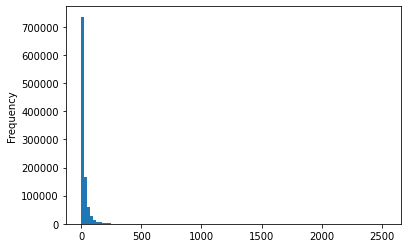

In [25]:
df_purged['len'].plot.hist(bins=100)

In [26]:
df_purged.len.quantile(0.9)

56.0